# Extended Data Fig 5

## Setup

In [1]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from triplets import *
from enrichments_data import *
from enrichments import *
from single_cell import *
from brainspan import *
from maps_data import *
from maps_analysis import *
from maps_null_test import *
from disorders_data import *
from disorders import *

In [3]:
%%R 
source("../code/fig_extended.R")


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


In [4]:
pca_base = gradientVersion(approach='pca', kernel=None).fit('hcp_base')
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


In [5]:
weights = dme_3d_ds5.weights.iloc[:,:3]
null_weights = shuffle_gene_weights(weights, n=5000, rank=False)

---

In [13]:
hcp_scores = dme_3d_ds5.clean_scores()
null_scores = np.load("../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000.npy")

In [7]:
maps_rename_dict = {
    'megdelta': 'Delta (δ: 2-4Hz)',
    'megtheta': 'Theta (θ: 5-7Hz)',
    'megalpha': 'Alpha (α: 8-12Hz)',
    'megbeta': 'Beta (β: 15-29Hz)',
    'meggamma1': 'Low Gamma (γ-low: 30-59Hz)',
    'meggamma2': 'High Gamma (γ-high: 60-90Hz)',
}

meg_maps = (pd.read_csv("../data/meg_HCPS1200.csv", index_col=0)
            .set_index(get_labels_hcp()[:180])
            .drop(['myelinmap','thickness','megtimescale'], axis=1)
            .apply(lambda x: (x-np.mean(x))/np.std(x))
            .loc[:, maps_rename_dict.keys()]
)

meg_maps_plot = meg_maps.rename(maps_rename_dict, axis=1)
meg_maps_plot

,Delta (δ: 2-4Hz),Theta (θ: 5-7Hz),Alpha (α: 8-12Hz),Beta (β: 15-29Hz),Low Gamma (γ-low: 30-59Hz),High Gamma (γ-high: 60-90Hz)
label,,,,,,
V1,-0.518782,-0.914991,1.346305,-0.950642,-1.171798,-0.802466
MST,-0.540194,-0.609940,1.164284,-0.718874,-1.223103,-0.805902
V6,-1.233396,-1.100668,1.788186,-0.323085,-1.179002,-1.144581
V2,-0.571531,-0.949788,1.355669,-0.836594,-1.013988,-0.649012
V3,-0.726571,-1.103299,1.506634,-0.729623,-0.963216,-0.653666
...,...,...,...,...,...,...
STSva,0.818639,-0.223971,-0.019938,-0.915546,-0.124024,0.743163
TE1m,0.450684,-0.239697,0.239870,-0.964469,-0.197460,0.812896
PI,0.807087,-0.169800,-0.058895,-0.725672,-0.193573,0.418686


In [14]:
meg_maps_scatter = (meg_maps
    .melt(ignore_index=False, var_name='map', value_name='map_score')
    .join(hcp_scores.set_index('label'))
    .melt(ignore_index=False, id_vars=['map','map_score'], var_name='C', value_name='C_score')
    .dropna(how='any')
    .assign(map = lambda x: pd.Categorical(x['map'], ordered=True, categories=meg_maps.columns))
)

In [15]:
meg_maps_null_p = (correlate_maps_with_null_scores(null_scores, hcp_scores.iloc[:,:3], meg_maps, reindex=True, adjust_by_label=True)
                .join(meg_maps_scatter.groupby(['map','C']).min(), on=('map','C'))
                .rename({'map_score':'y', 'C_score':'x'}, axis=1)
)
meg_maps_null_p

,C,map,r,p,q,y,x
0,C1,megdelta,-0.605172,0.129574,0.312338,-2.142903,-1.919552
1,C1,megtheta,-0.179429,0.740252,0.740252,-2.557151,-1.919552
2,C1,megalpha,0.642530,0.156169,0.312338,-1.648018,-1.919552
3,C1,megbeta,0.427957,0.394121,0.492142,-2.456039,-1.919552
4,C1,meggamma1,-0.414997,0.410118,0.492142,-1.509459,-1.919552
5,C1,meggamma2,-0.641005,0.063387,0.312338,-1.281127,-1.919552
6,C2,megdelta,0.269638,0.667267,0.800720,-2.142903,-2.126559
7,C2,megtheta,0.781385,0.008598,0.051590,-2.557151,-2.126559
8,C2,megalpha,-0.542853,0.385723,0.578584,-1.648018,-2.126559
9,C2,megbeta,0.628746,0.222555,0.549890,-2.456039,-2.126559


In [16]:
meg_maps_null_p = (meg_maps_null_p
                    .assign(map = lambda x: pd.Categorical(x['map'], ordered=True, categories=meg_maps.columns))
                    .drop(['y','x'], axis=1)
                    .join(meg_maps_scatter.groupby(['map','C'])
                          .agg({'map_score':'min', 'C_score':'min'}), on=('map','C'))
                    .rename({'map_score':'y', 'C_score':'x'},axis=1)
)

/opt/conda/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '




`geom_smooth()` using formula = 'y ~ x'


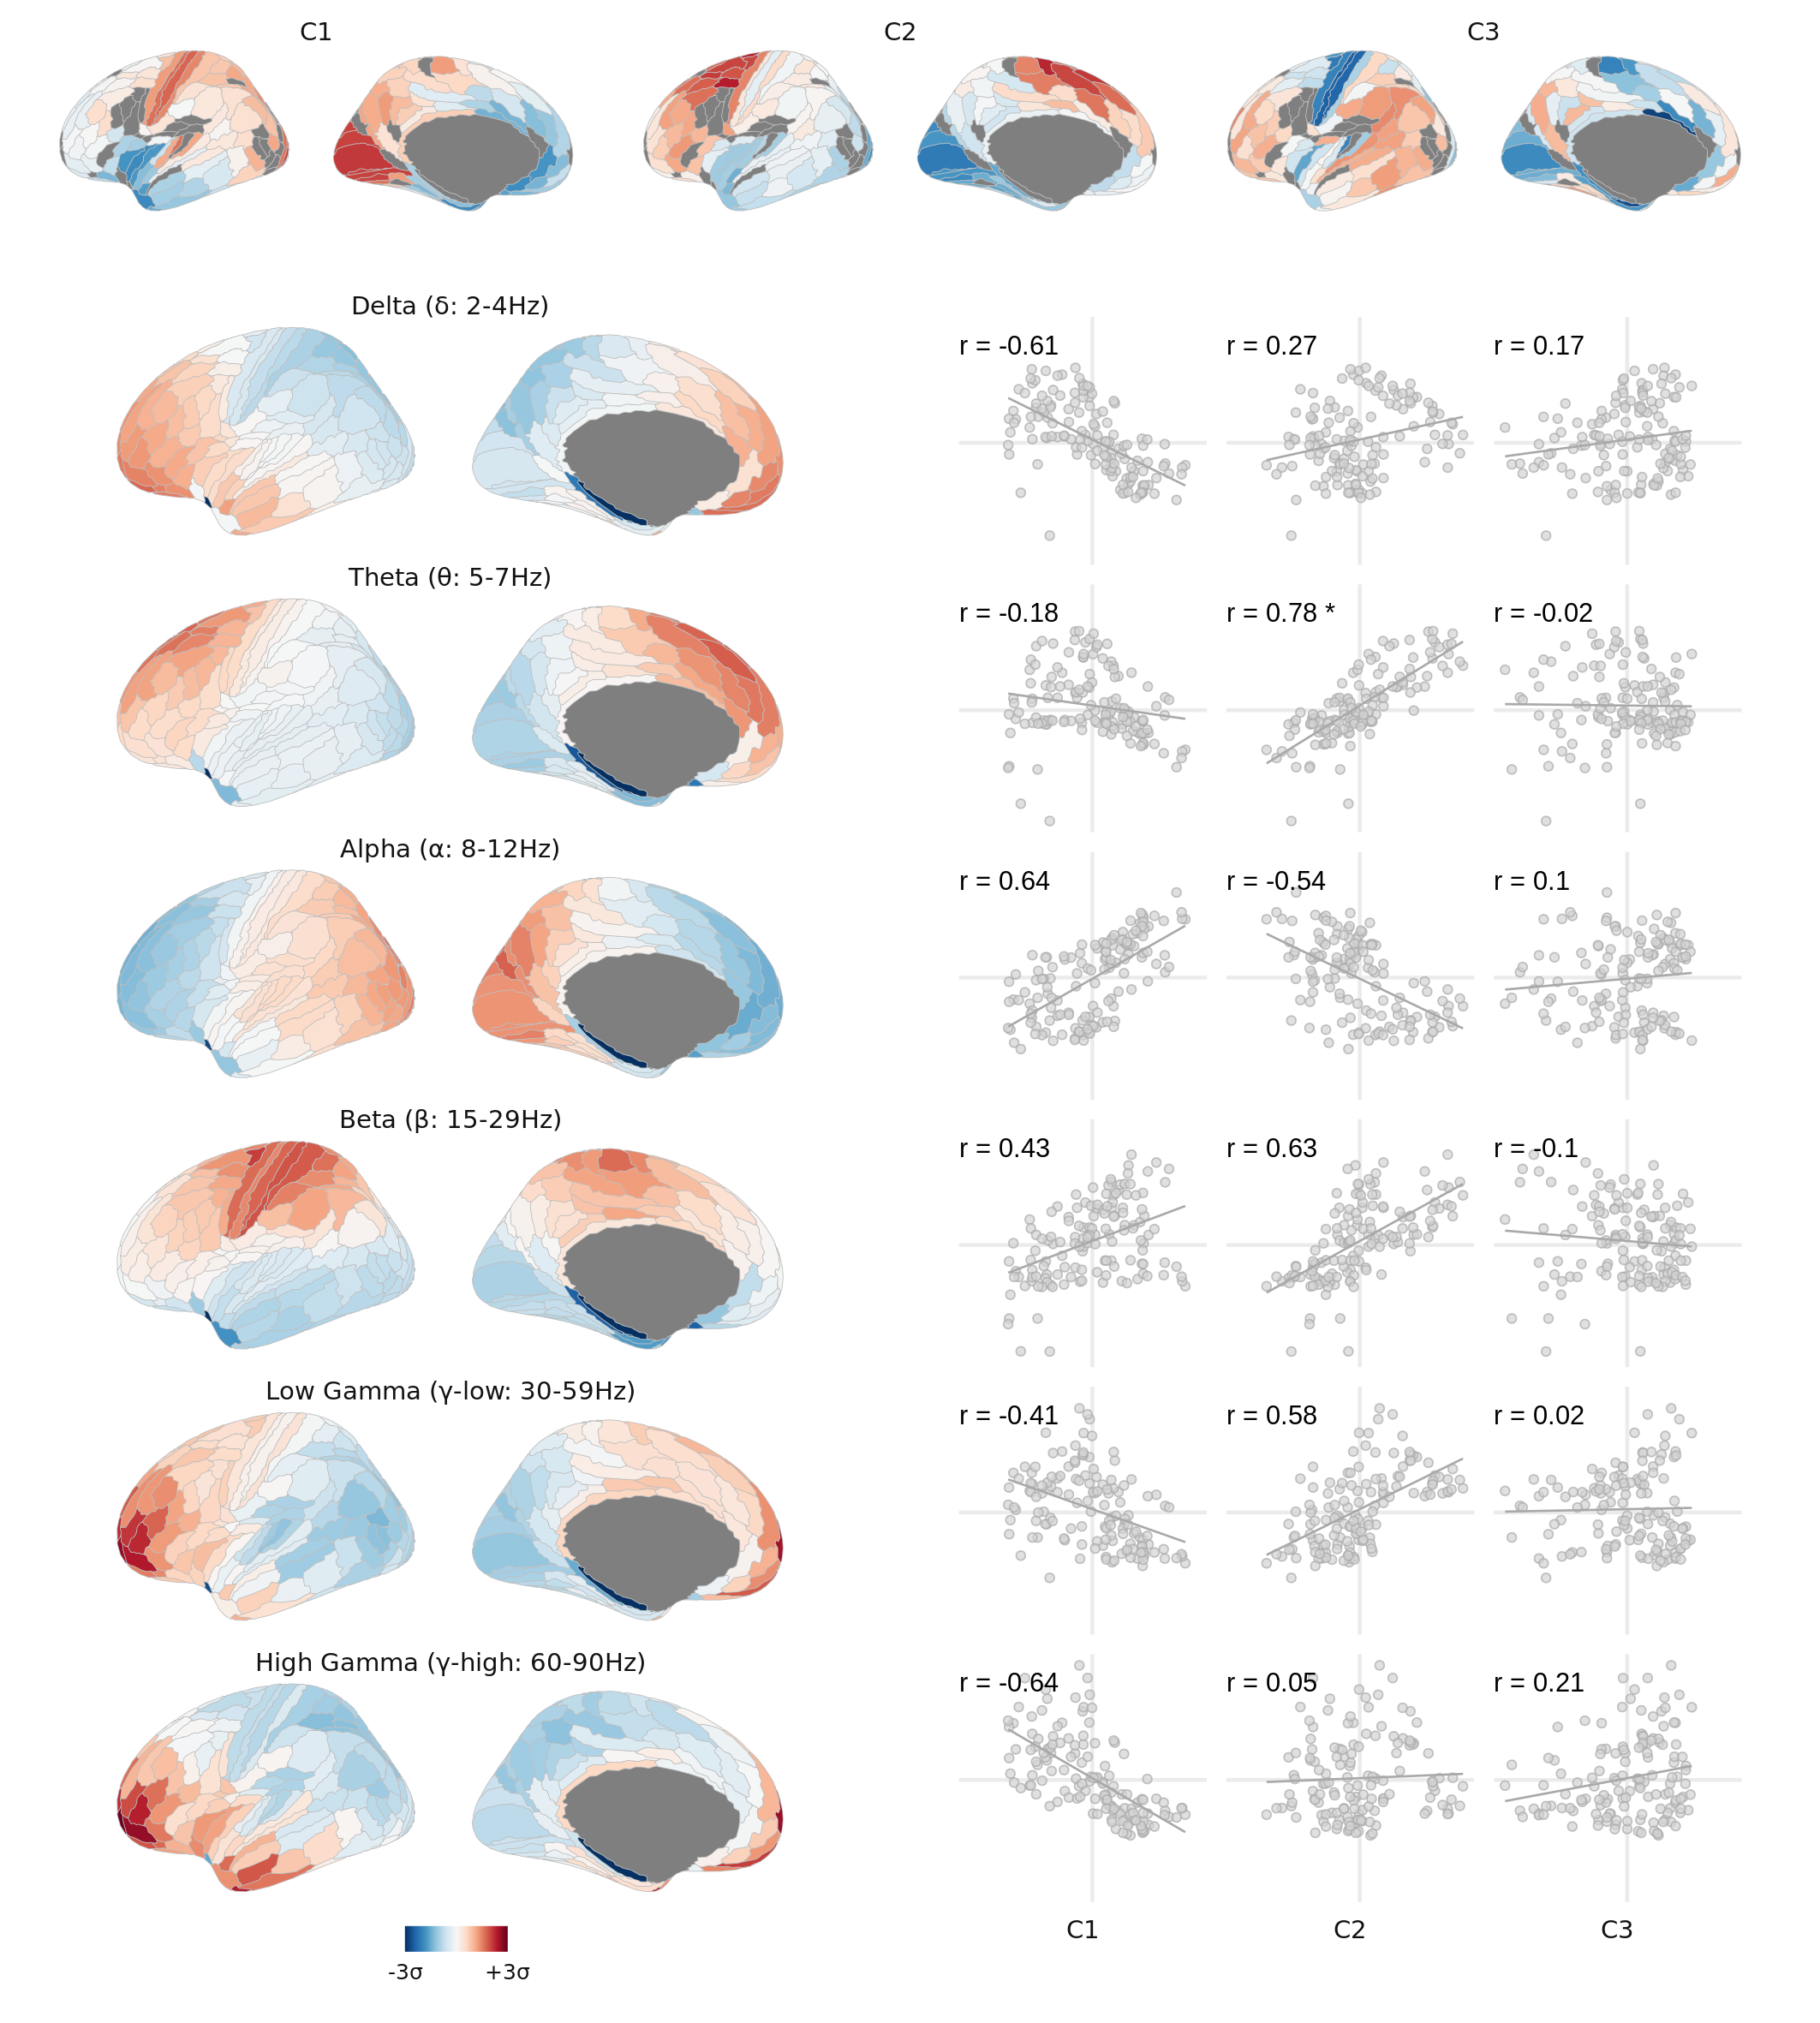

In [19]:
%%R -i hcp_scores -i meg_maps_plot -i meg_maps_scatter -i meg_maps_null_p -w 180 -h 200 --units mm -r 300
source("../code/fig_extended.R")
p0 <- plot_brains(hcp_scores, ncol=3, facet='w', legend_pos='none', strip=TRUE)
p1 <- plot_brains(meg_maps_plot, ncol=1, facet='w', legend_pos='bottom', strip=TRUE) + theme(legend.margin=margin(-5,0,0,0,'mm'))
p2 <- plot_maps_scatter(meg_maps_scatter, meg_maps_null_p)
design <- c(
    area(t=1,b=20,l=1,r=180),
    area(t=21,b=200,l=1,r=90),
    area(t=21,b=200,l=91,r=180)
)

annotated <- p0 + p1 + p2 + plot_layout(design=design)
annotated

In [20]:
%%R
ggsave(file="../outputs/figures/fig_ext_5.svg", plot=annotated, width=180, height=200, units='mm')

`geom_smooth()` using formula = 'y ~ x'
